# Buckeye test set evaluation: Post-processing to shared symbol set


If you normalize the model outputs and gold standards to a reduced, shared symbol set, how does performance change? 

In [1]:
from pathlib import Path
import regex as re

import matplotlib
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import numpy as np
import pandas as pd
from phonecodes import phonecodes
import seaborn as sns

import multipa.evaluation
import multipa.evaluation_extras

# Key/column constants for convenience
EXP_GROUP_DISPLAY_KEY = "Experiment group"
EXP_LABEL_KEY = "experiment_label"
EXP_GROUP_KEY = "experiment_group"
EXP_ID_KEY = "experiment_id"
MODEL_SOURCE_KEY = "Model source"

EVAL_PATH = Path("../../data/evaluation_results/detailed_predictions/")

BEST_OUT_CSV = "best_experiments_in_group.csv" # Generated by amp_evaluation_analysis.ipynb
BEST_OUT_POSTPROC_CSV = "best_experiments_post_processing.csv"
ALL_MODEL_AVG_CSV = "all_model_averages_post_processing.csv"
SAVE_ALL_CSV = "buckeye_post_processing_evaluation.csv"

VIZ_OUTPUT_DIR = Path("../paper_viz")
VIZ_OUTPUT_DIR.mkdir(exist_ok=True)

/Users/virginia/miniconda3/envs/multipa/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# Visualization settings
font = {"size": 16}
matplotlib.rc("font", **font)
plt.rcParams["figure.figsize"] = (12, 12)

# Remove the limits on the number of rows, columns displayed in the notebook
pd.options.display.max_rows = None
pd.options.display.max_columns = None
pd.options.display.max_colwidth = None

PALETTE = "colorblind"
FONT_SCALE = 2
CONTEXT = "paper"
sns.set_palette(PALETTE)
sns.set_context(context=CONTEXT, font_scale=FONT_SCALE)

In [3]:
# Define settings to read and post-process results from external baselines
EXTERNAL_PREDICTION_CSVS = [
    EVAL_PATH / "allosaurus_eng2102_eng_detailed_predictions.csv",
    EVAL_PATH
    / "ctaguchi_wav2vec2-large-xlsr-japlmthufielta-ipa1000-ns_detailed_predictions.csv",
    EVAL_PATH / "facebook_wav2vec2-lv-60-espeak-cv-ft_detailed_predictions.csv",
    #EVAL_PATH / "facebook_wav2vec2-xlsr-53-espeak-cv-ft_detailed_predictions.csv",
    EVAL_PATH / "openai_whisper-large-v3-turbo_to_epitran_detailed_predictions.csv",
    EVAL_PATH / "openai_whisper-medium.en_to_epitran_detailed_predictions.csv",
    EVAL_PATH / "excalibur12_wav2vec2-large-lv60_phoneme-timit_english_timit-4k_detailed_predictions.csv",
    EVAL_PATH / "excalibur12_wav2vec2-large-lv60_phoneme-timit_english_timit-4k_simplified_detailed_predictions.csv"
]
EXTERNAL_NAME_PATTERN = re.compile(r"[\w-\.]+(?=_detailed_predictions.csv)")


In [4]:
# Define settings to read and post-process results from our models fine-tuned on Buckeye
EXPERIMENT_PREDICTION_CSVS = list(
    EVAL_PATH.glob("data_models_*_detailed_predictions.csv")
) + list(EVAL_PATH.glob("ginic_*_detailed_predictions.csv"))
EXPERIMENT_PREDICTION_CSVS = [file for file in EXPERIMENT_PREDICTION_CSVS if "hyperparams" not in str(file)]
# Use to pull the experiment name and number id from the file name
EXP_NAME_PATTERN = re.compile(
    r"(?<=(data_models_)|(ginic_))[\w-]+(?=_wav2vec2-large-xlsr-53-buckeye-ipa_detailed_predictions.csv|_wav2vec2-large-lv60_phoneme-timit_english_timit-4k-buckeye-ipa_detailed_predictions.csv)"
)

# For the purposes of this analysis, just use the data_seed, full_dataset_train and train_duration_20000 experiment groups
EXPERIMENT_GROUP_DESCRIPTIONS = {
    "data_seed": "Buckeye fine-tuned: balanced gender",
    "full_dataset_train": "Buckeye fine-tuned on full train split",
}

In [5]:
def get_experiment_label(full_exp_name, pattern):
    """Parse out the experiment label from the file name
    Experiment label are some brief description (\w chars) followed by _ and a single digit

    Args:
        full_exp_name (str): Filename for experiment results, starts with 'data_model_" followed by the experiment label and ends with "_detailed_predictions.csv"

    Returns:
        str: full experiment label
    """
    experiment_id = pattern.search(full_exp_name)
    return experiment_id.group(0)

In [6]:
# Read and post-process gold standard transcriptions to the shared symbol set
gold_transcriptions_df = pd.read_csv(EXPERIMENT_PREDICTION_CSVS[0], usecols=["utterance_id", "ipa"], keep_default_na=False).set_index("utterance_id")
print("Snippet before post-processing")
print("Shape:", gold_transcriptions_df.shape)
display(gold_transcriptions_df.head())
gold_transcriptions_df["ipa"] = gold_transcriptions_df["ipa"].apply(lambda x: multipa.evaluation_extras.greedy_reduction_find_and_replace(x, multipa.evaluation_extras.BUCKEYE_REDUCED_MAPPING))
print("Snippet after post-processing")
gold_shape = gold_transcriptions_df.shape
print("Shape:", gold_shape)
display(gold_transcriptions_df.head())


Snippet before post-processing
Shape: (5079, 1)


,ipa
utterance_id,
s2501a_Utt0,fɔɹfaɪv
s2501a_Utt1,uʌɾ̃aɪheɪʔhiɹɪnmaɪsɛlfɑn
s2501a_Utt2,ʌkeɪʌmaɪʔwɑnnʌtʃɹaɪɾʊɪdʒʌssɪsʌlɪɾl̩bɪɾɪɡɛnɪfjʌseɪɪʔɡuzʌnɹ̩maɪpʊɾn̩ɪdʌndɹ̩hɪɹhɛlp
s2501a_Utt3,nɑtɪʔʌzbɛɾɹ̩bɪfɔɹ
s2501a_Utt4,ðɛɹ


Snippet after post-processing
Shape: (5079, 1)


,ipa
utterance_id,
s2501a_Utt0,fɔɹfaɪv
s2501a_Utt1,uənaɪheɪʔhiɹɪnmaɪsɛlfɑn
s2501a_Utt2,əkeɪəmaɪʔwɑnnətʃɹaɪɾʊɪdʒəssɪsəlɪɾl̩bɪɾɪɡɛnɪfjəseɪɪʔɡuzənɹ̩maɪpʊɾn̩ɪdəndɹ̩hɪɹhɛlp
s2501a_Utt3,nɑtɪʔəzbɛɾɹ̩bɪfɔɹ
s2501a_Utt4,ðɛɹ


In [7]:
# Read CSVs for desired experiments with "utterance_id" column as the index
# Do pre-processing for symbol reduction on the "prediction" column
# Also compute evaluation metrics for each model's post-processed transcription
all_dataframes = []
final_eval_records = []
MODEL_EVALUATOR = multipa.evaluation.ModelEvaluator()

# Our models that were fine-tuned on Buckeye
for csv in EXPERIMENT_PREDICTION_CSVS:
    # We're only paying attention to a subset of experiments here
    keep_exp = False
    experiment_label = get_experiment_label(csv.name, EXP_NAME_PATTERN)
    experiment_group = experiment_label[:-2]
    experiment_id = experiment_label[-1:]
    print(csv.name, "Label:", experiment_label, "Group:", experiment_group, "Experiment id:", experiment_id)
    if experiment_group.startswith("train_duration_20000"):
        exp_display_key = "Buckeye fine-tuned on full gender balanced train set"
        keep_exp = True
    elif experiment_group.startswith("fine_tune"):
        exp_display_key = "Lee 2025 fine-tuned again on Buckeye"
        keep_exp = True
    else:
        for k, v in EXPERIMENT_GROUP_DESCRIPTIONS.items():
            if experiment_group.startswith(k):
                exp_display_key = v
                keep_exp = True
                break
    if keep_exp:
        dataframe = pd.read_csv(csv, usecols=["utterance_id", multipa.evaluation.PREDICTION_KEY], keep_default_na=False).set_index("utterance_id")
        # Sanity check dataframe shape matches gold transcriptions
        assert dataframe.shape==gold_shape
        # Post-process predictions to reduced IPA symbol set
        dataframe[EXP_LABEL_KEY] = experiment_label
        dataframe[EXP_GROUP_KEY] = experiment_group
        dataframe[EXP_ID_KEY] = experiment_id
        dataframe[EXP_GROUP_DISPLAY_KEY] = exp_display_key
        dataframe[MODEL_SOURCE_KEY] = "Buckeye fine-tuned"
        dataframe[multipa.evaluation.PREDICTION_KEY] = dataframe[multipa.evaluation.PREDICTION_KEY].apply(lambda x: multipa.evaluation_extras.greedy_reduction_find_and_replace(x, multipa.evaluation_extras.BUCKEYE_REDUCED_MAPPING))
        dataframe = dataframe.join(gold_transcriptions_df, how="inner")
        # Compute metrics on post_processed labels and add to dataframe
        print("Computing metrics for", experiment_label)
        metrics = MODEL_EVALUATOR.eval_non_empty_transcriptions(experiment_label, dataframe[multipa.evaluation.PREDICTION_KEY], dataframe["ipa"])
        for k, v in metrics.items():
            dataframe[k] = v
        all_dataframes.append(dataframe)


for csv in EXTERNAL_PREDICTION_CSVS:
    # Read predictions and set model metadata
    experiment_label = get_experiment_label(csv.name, EXTERNAL_NAME_PATTERN)
    experiment_group = experiment_label
    experiment_id = 1
    print(csv.name, "Label:", experiment_label, "Group:", experiment_group, "Experiment id:", experiment_id)
    dataframe = pd.read_csv(csv, usecols=["utterance_id", multipa.evaluation.PREDICTION_KEY], keep_default_na=False).set_index("utterance_id")
    assert dataframe.shape==gold_shape
    dataframe[EXP_LABEL_KEY] = experiment_label
    dataframe[EXP_GROUP_KEY] = experiment_group
    dataframe[EXP_ID_KEY] = experiment_id
    if experiment_label.startswith("allosaurus"):
        dataframe[EXP_GROUP_DISPLAY_KEY] = "Allosaurus English"
        dataframe[MODEL_SOURCE_KEY] = "Allosaurus English"
    elif experiment_label.startswith("ctaguchi"):
        dataframe[EXP_GROUP_DISPLAY_KEY] = "Taguchi et al. 2023"
        dataframe[MODEL_SOURCE_KEY] = "Taguchi et al. 2023"
    elif "whisper" in experiment_label:
        dataframe[EXP_GROUP_DISPLAY_KEY] = "Whisper + Epitran"
        dataframe[MODEL_SOURCE_KEY] = "Whisper + Epitran"
    elif "excalibur12_wav2vec2" in experiment_label:
        if experiment_label.endswith("simplified"):
            display_key = "Lee 2025 wav2vec 2.0 TIMIT fine-tuned"
        else:
            display_key = "Lee 2025 wav2vec 2.0 TIMIT fine-tuned (simplified)"
        dataframe[EXP_GROUP_DISPLAY_KEY] = display_key
        dataframe[MODEL_SOURCE_KEY] = display_key
    elif experiment_label.startswith("facebook_wav2vec2"):
        dataframe[EXP_GROUP_DISPLAY_KEY] = "facebook/wav2vec2-lv-60-espeak-cv-ft"
        dataframe[MODEL_SOURCE_KEY] = "facebook/wav2vec2-lv-60-espeak-cv-ft"
    else:
        # Skip any models that aren't listed here
        print(f"Unknown experiment label: {experiment_label}")
        continue

    # Post-process predictions
    dataframe[multipa.evaluation.PREDICTION_KEY] = dataframe[multipa.evaluation.PREDICTION_KEY].apply(lambda x: multipa.evaluation_extras.greedy_reduction_find_and_replace(x, multipa.evaluation_extras.TIMIT_AND_OTHER_REDUCED_MAPPING))
    dataframe = dataframe.join(gold_transcriptions_df, how="inner")
    # Compute metrics on post_processed labels and add to dataframe
    print("Computing metrics for", experiment_label)
    metrics = MODEL_EVALUATOR.eval_non_empty_transcriptions(experiment_label, dataframe[multipa.evaluation.PREDICTION_KEY], dataframe["ipa"])
    for k, v in metrics.items():
        dataframe[k] = v

    all_dataframes.append(dataframe)

all_data = pd.concat(all_dataframes)
# Write for later in case the kernel dies or something
all_data.to_csv(SAVE_ALL_CSV)
all_data.head()



data_models_gender_split_0_female_2_wav2vec2-large-xlsr-53-buckeye-ipa_detailed_predictions.csv Label: gender_split_0_female_2 Group: gender_split_0_female Experiment id: 2
data_models_train_duration_100_samples_5_wav2vec2-large-xlsr-53-buckeye-ipa_detailed_predictions.csv Label: train_duration_100_samples_5 Group: train_duration_100_samples Experiment id: 5
data_models_gender_split_100_female_1_wav2vec2-large-xlsr-53-buckeye-ipa_detailed_predictions.csv Label: gender_split_100_female_1 Group: gender_split_100_female Experiment id: 1
data_models_train_duration_800_samples_5_wav2vec2-large-xlsr-53-buckeye-ipa_detailed_predictions.csv Label: train_duration_800_samples_5 Group: train_duration_800_samples Experiment id: 5
data_models_train_duration_200_samples_4_wav2vec2-large-xlsr-53-buckeye-ipa_detailed_predictions.csv Label: train_duration_200_samples_4 Group: train_duration_200_samples Experiment id: 4
data_models_train_duration_12800_samples_3_wav2vec2-large-xlsr-53-buckeye-ipa_detail

,prediction,experiment_label,experiment_group,experiment_id,Experiment group,Model source,ipa,phone_error_rates,mean_phone_error_rate,phone_feature_error_rates,mean_phone_feature_error_rate,feature_error_rates,mean_feature_error_rate,substitutions,deletions,insertions
utterance_id,,,,,,,,,,,,,,,,
s2501a_Utt0,fɔɹɹ̩faɪv,train_duration_20000_samples_4,train_duration_20000_samples,4,Buckeye fine-tuned on full gender balanced train set,Buckeye fine-tuned,fɔɹfaɪv,0.142857,0.244749,1.000000,3.800363,0.264881,0.143927,{},{},{'ɹ̩': 1}
s2501a_Utt1,uɛnaɪheɪʔhiɹn̩maɪsɛlfɑntɡʊ,train_duration_20000_samples_4,train_duration_20000_samples,4,Buckeye fine-tuned on full gender balanced train set,Buckeye fine-tuned,uənaɪheɪʔhiɹɪnmaɪsɛlfɑn,0.260870,0.244749,4.083333,3.800363,0.055254,0.143927,"{('ə', 'ɛ'): 1, ('ɪ', 'n̩'): 1}",{'n': 1},"{'t': 1, 'ɡ': 1, 'ʊ': 1}"
s2501a_Utt2,aɪkeɪɛwaɪwɑnətʃɹaɪdəsɪɡoʊzənɹ̩hiɹəsteɪbɛɹ̩ts,train_duration_20000_samples_4,train_duration_20000_samples,4,Buckeye fine-tuned on full gender balanced train set,Buckeye fine-tuned,əkeɪəmaɪʔwɑnnətʃɹaɪɾʊɪdʒəssɪsəlɪɾl̩bɪɾɪɡɛnɪfjəseɪɪʔɡuzənɹ̩maɪpʊɾn̩ɪdəndɹ̩hɪɹhɛlp,0.684211,0.244749,37.958333,3.800363,0.146107,0.143927,"{('ə', 'a'): 1, ('ə', 'ɛ'): 1, ('m', 'w'): 1, ('ɛ', 'o'): 1, ('n', 'ʊ'): 1, ('m', 'h'): 1, ('a', 'i'): 1, ('ɪ', 'ɹ'): 1, ('n', 's'): 1, ('d', 't'): 1, ('ɹ̩', 'e'): 1, ('ɹ', 'b'): 1, ('l', 'ɹ̩'): 1, ('p', 't'): 1}","{'ʔ': 2, 'n': 1, 'ɾ': 4, 'ʊ': 2, 'ɪ': 8, 'ʒ': 1, 's': 3, 'ə': 2, 'l': 1, 'l̩': 1, 'b': 1, 'f': 1, 'j': 1, 'e': 1, 'ɡ': 1, 'u': 1, 'p': 1, 'n̩': 1, 'd': 1, 'h': 2}","{'ɪ': 1, 's': 1}"
s2501a_Utt3,nəʔɪʔəzbɛɾɹ̩bɪfɔɹ,train_duration_20000_samples_4,train_duration_20000_samples,4,Buckeye fine-tuned on full gender balanced train set,Buckeye fine-tuned,nɑtɪʔəzbɛɾɹ̩bɪfɔɹ,0.125000,0.244749,0.375000,3.800363,0.020833,0.143927,"{('ɑ', 'ə'): 1, ('t', 'ʔ'): 1}",{},{}
s2501a_Utt4,ðɛɹ,train_duration_20000_samples_4,train_duration_20000_samples,4,Buckeye fine-tuned on full gender balanced train set,Buckeye fine-tuned,ðɛɹ,0.000000,0.244749,0.000000,3.800363,0.000000,0.143927,{},{},{}


In [8]:
all_data = pd.read_csv(SAVE_ALL_CSV)

In [9]:
# Overall average error rates for each individual model
by_model_avg_metrics = (
    all_data.groupby(
        [
            EXP_LABEL_KEY, EXP_GROUP_KEY, EXP_GROUP_DISPLAY_KEY, MODEL_SOURCE_KEY #last 3 keys are added just so we don't have to join them in later
        ]
    )[["phone_error_rates", "phone_feature_error_rates", "feature_error_rates"]]
    .mean()
    .sort_values(by="phone_error_rates")
    .reset_index()
)
by_model_avg_metrics.to_csv(ALL_MODEL_AVG_CSV)
display(by_model_avg_metrics.head(20))

,experiment_label,experiment_group,Experiment group,Model source,phone_error_rates,phone_feature_error_rates,feature_error_rates
0,train_duration_20000_samples_4,train_duration_20000_samples,Buckeye fine-tuned on full gender balanced train set,Buckeye fine-tuned,0.244749,3.800363,0.143927
1,train_duration_20000_samples_3,train_duration_20000_samples,Buckeye fine-tuned on full gender balanced train set,Buckeye fine-tuned,0.245551,3.774865,0.143806
2,full_dataset_train_5,full_dataset_train,Buckeye fine-tuned on full train split,Buckeye fine-tuned,0.247910,3.829363,0.141993
3,full_dataset_train_1,full_dataset_train,Buckeye fine-tuned on full train split,Buckeye fine-tuned,0.248774,3.766284,0.142187
4,full_dataset_train_4,full_dataset_train,Buckeye fine-tuned on full train split,Buckeye fine-tuned,0.250785,3.863974,0.144347
5,train_duration_20000_samples_1,train_duration_20000_samples,Buckeye fine-tuned on full gender balanced train set,Buckeye fine-tuned,0.251124,3.903820,0.144189
6,full_dataset_train_2,full_dataset_train,Buckeye fine-tuned on full train split,Buckeye fine-tuned,0.251812,3.893007,0.145654
7,train_duration_20000_samples_5,train_duration_20000_samples,Buckeye fine-tuned on full gender balanced train set,Buckeye fine-tuned,0.253493,3.850766,0.145916
8,full_dataset_train_3,full_dataset_train,Buckeye fine-tuned on full train split,Buckeye fine-tuned,0.255051,3.916839,0.145506
9,train_duration_20000_samples_2,train_duration_20000_samples,Buckeye fine-tuned on full gender balanced train set,Buckeye fine-tuned,0.256836,4.241846,0.143774


In [10]:
# Limit to only the best performing model in each group
best_experiment_in_group = (
    by_model_avg_metrics.groupby([EXP_GROUP_DISPLAY_KEY, MODEL_SOURCE_KEY])[
        [EXP_LABEL_KEY, "phone_error_rates", "phone_feature_error_rates", "feature_error_rates"]
    ]
    .first()
    .reset_index()
    .sort_values(by="phone_error_rates")
)

display(best_experiment_in_group)
best_experiment_in_group.to_csv(BEST_OUT_POSTPROC_CSV)

,Experiment group,Model source,experiment_label,phone_error_rates,phone_feature_error_rates,feature_error_rates
1,Buckeye fine-tuned on full gender balanced train set,Buckeye fine-tuned,train_duration_20000_samples_4,0.244749,3.800363,0.143927
2,Buckeye fine-tuned on full train split,Buckeye fine-tuned,full_dataset_train_5,0.247910,3.829363,0.141993
4,Lee 2025 fine-tuned again on Buckeye,Buckeye fine-tuned,fine_tune_data_seed_bs32_3,0.258847,3.780321,0.140111
3,Buckeye fine-tuned: balanced gender,Buckeye fine-tuned,data_seed_bs64_1,0.271523,4.184707,0.146766
5,Lee 2025 wav2vec 2.0 TIMIT fine-tuned,Lee 2025 wav2vec 2.0 TIMIT fine-tuned,excalibur12_wav2vec2-large-lv60_phoneme-timit_english_timit-4k_simplified,0.450098,5.430014,0.175985
6,Lee 2025 wav2vec 2.0 TIMIT fine-tuned (simplified),Lee 2025 wav2vec 2.0 TIMIT fine-tuned (simplified),excalibur12_wav2vec2-large-lv60_phoneme-timit_english_timit-4k,0.464065,5.472854,0.181083
8,Whisper + Epitran,Whisper + Epitran,openai_whisper-medium.en_to_epitran,0.523171,7.241353,0.174706
9,facebook/wav2vec2-lv-60-espeak-cv-ft,facebook/wav2vec2-lv-60-espeak-cv-ft,facebook_wav2vec2-lv-60-espeak-cv-ft,0.553146,5.921441,0.167059
0,Allosaurus English,Allosaurus English,allosaurus_eng2102_eng,0.635966,7.502732,0.172712
7,Taguchi et al. 2023,Taguchi et al. 2023,ctaguchi_wav2vec2-large-xlsr-japlmthufielta-ipa1000-ns,0.758307,8.056638,0.201176


/var/folders/7c/4fzv15450s1bt_03bv1b6hb80000gn/T/ipykernel_24311/727621879.py:9: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  g.set_xticklabels(g.get_xticklabels(), rotation=30, horizontalalignment="right")
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


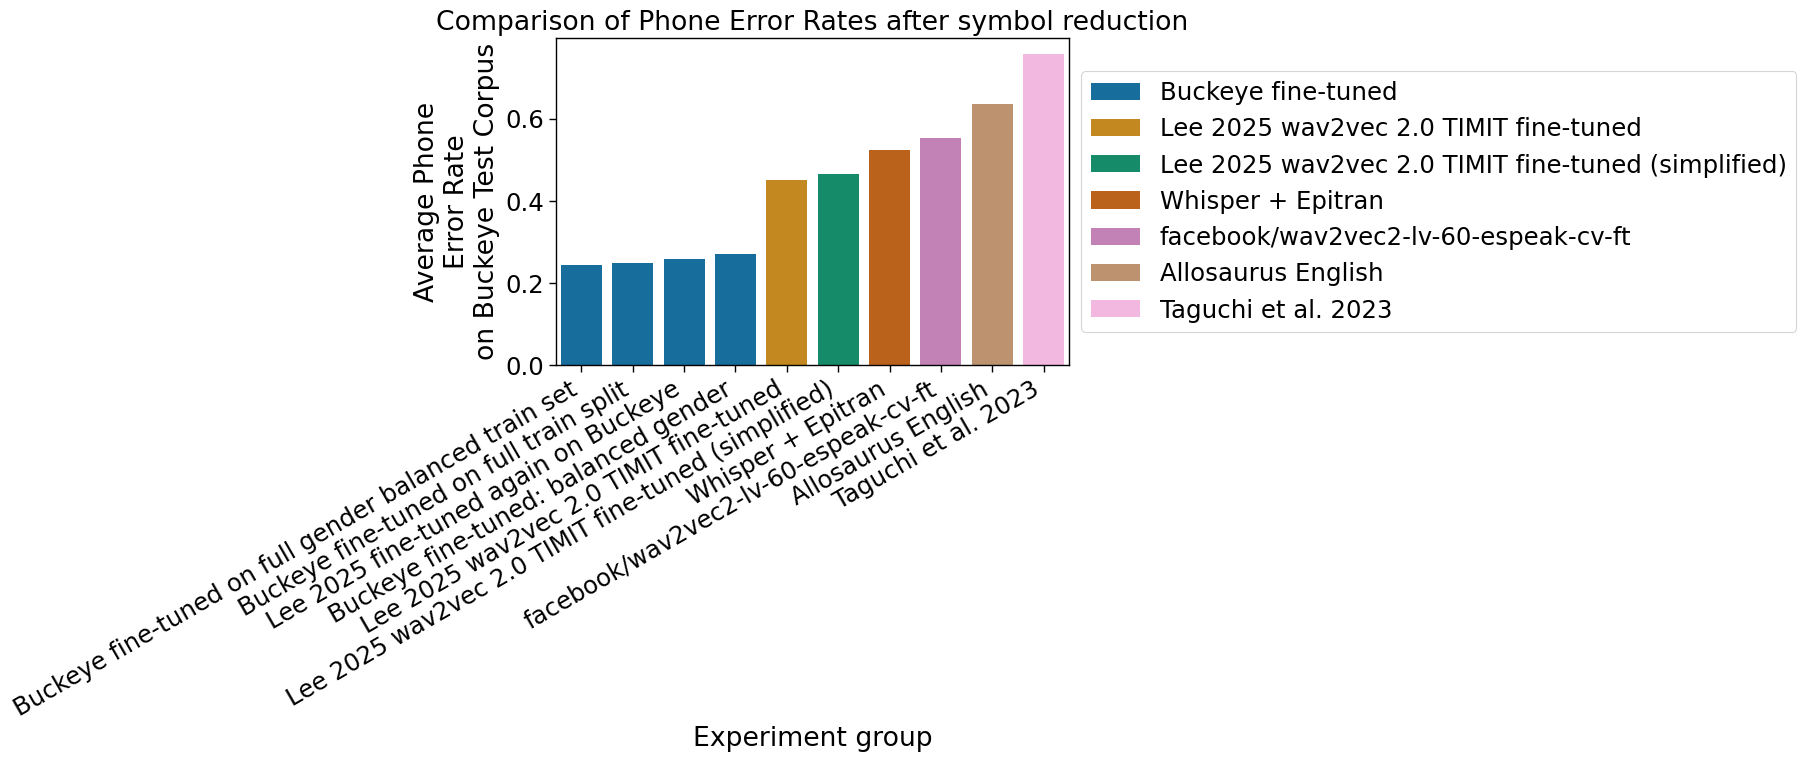

In [18]:
plt.figure(figsize=(18, 8))
g = sns.barplot(
    data=best_experiment_in_group,
    x=EXP_GROUP_DISPLAY_KEY,
    y="phone_error_rates",
    hue="Model source",
    palette=PALETTE,
)
g.set_xticklabels(g.get_xticklabels(), rotation=30, horizontalalignment="right")
g.set_title("Comparison of Phone Error Rates after symbol reduction")
g.set_ylabel("Average Phone\nError Rate\non Buckeye Test Corpus")
plt.legend(bbox_to_anchor=(1.0, 0.5), loc="center left")
plt.tight_layout()
plt.savefig(VIZ_OUTPUT_DIR / "buckeye_post_symbol_reduction.eps", format="eps")

/var/folders/7c/4fzv15450s1bt_03bv1b6hb80000gn/T/ipykernel_24311/2606268987.py:9: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  g.set_xticklabels(g.get_xticklabels(), rotation=30, horizontalalignment="right")


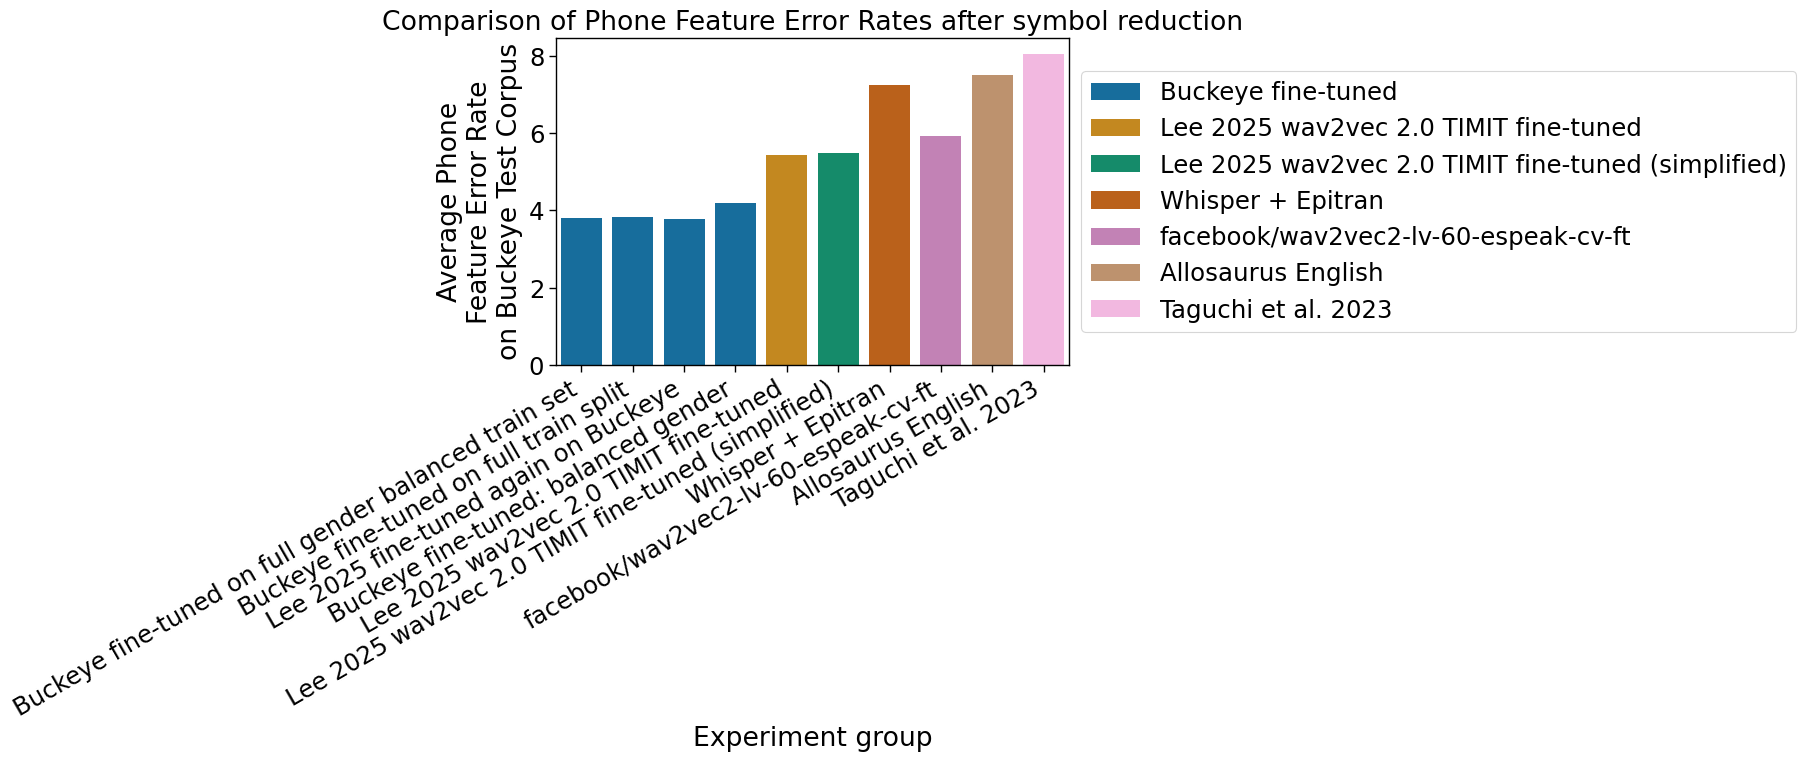

In [19]:
plt.figure(figsize=(18, 8))
g = sns.barplot(
    data=best_experiment_in_group,
    x=EXP_GROUP_DISPLAY_KEY,
    y="phone_feature_error_rates",
    hue="Model source",
    palette=PALETTE,
)
g.set_xticklabels(g.get_xticklabels(), rotation=30, horizontalalignment="right")
g.set_title("Comparison of Phone Feature Error Rates after symbol reduction")
g.set_ylabel("Average Phone\nFeature Error Rate\non Buckeye Test Corpus")
plt.legend(bbox_to_anchor=(1.0, 0.5), loc="center left")
plt.tight_layout()

In [22]:
# Read and join best experiments without symbol reduction
symbol_reduction_key = "symbol reduction"
original_best_exp = pd.read_csv(BEST_OUT_CSV)
print(original_best_exp.shape)
original_best_exp[symbol_reduction_key] = False

best_reduction_exp = best_experiment_in_group.copy()
best_reduction_exp[symbol_reduction_key] = True
original_best_exp = pd.merge(original_best_exp, best_reduction_exp[[EXP_GROUP_DISPLAY_KEY, MODEL_SOURCE_KEY]], how="inner", on=[EXP_GROUP_DISPLAY_KEY, MODEL_SOURCE_KEY])
print(original_best_exp.shape)
print(original_best_exp.columns)
print(best_reduction_exp.shape)
print(best_reduction_exp.columns)
joined_best_exp = pd.concat([original_best_exp, best_reduction_exp])
# Update display names
joined_best_exp.loc[joined_best_exp[MODEL_SOURCE_KEY] == "Lee 2025 wav2vec 2.0 TIMIT fine-tuned", [MODEL_SOURCE_KEY]] = "Lee 2025 wav2vec 2.0\nTIMIT fine-tuned"
joined_best_exp.loc[joined_best_exp[MODEL_SOURCE_KEY] == "Lee 2025 wav2vec 2.0 TIMIT fine-tuned (simplified)", [MODEL_SOURCE_KEY]] = "Lee 2025 wav2vec 2.0\nTIMIT fine-tuned (simplified)"
joined_best_exp.loc[joined_best_exp[MODEL_SOURCE_KEY] =="facebook/wav2vec2-lv-60-espeak-cv-ft", [MODEL_SOURCE_KEY]] = "facebook/wav2vec2\n-lv-60-espeak-cv-ft"



(23, 6)
(8, 7)
Index(['Experiment group', 'Model source', 'experiment_label',
       'phone_error_rates', 'phone_feature_error_rates', 'feature_error_rates',
       'symbol reduction'],
      dtype='object')
(10, 7)
Index(['Experiment group', 'Model source', 'experiment_label',
       'phone_error_rates', 'phone_feature_error_rates', 'feature_error_rates',
       'symbol reduction'],
      dtype='object')


<Figure size 800x1200 with 0 Axes>

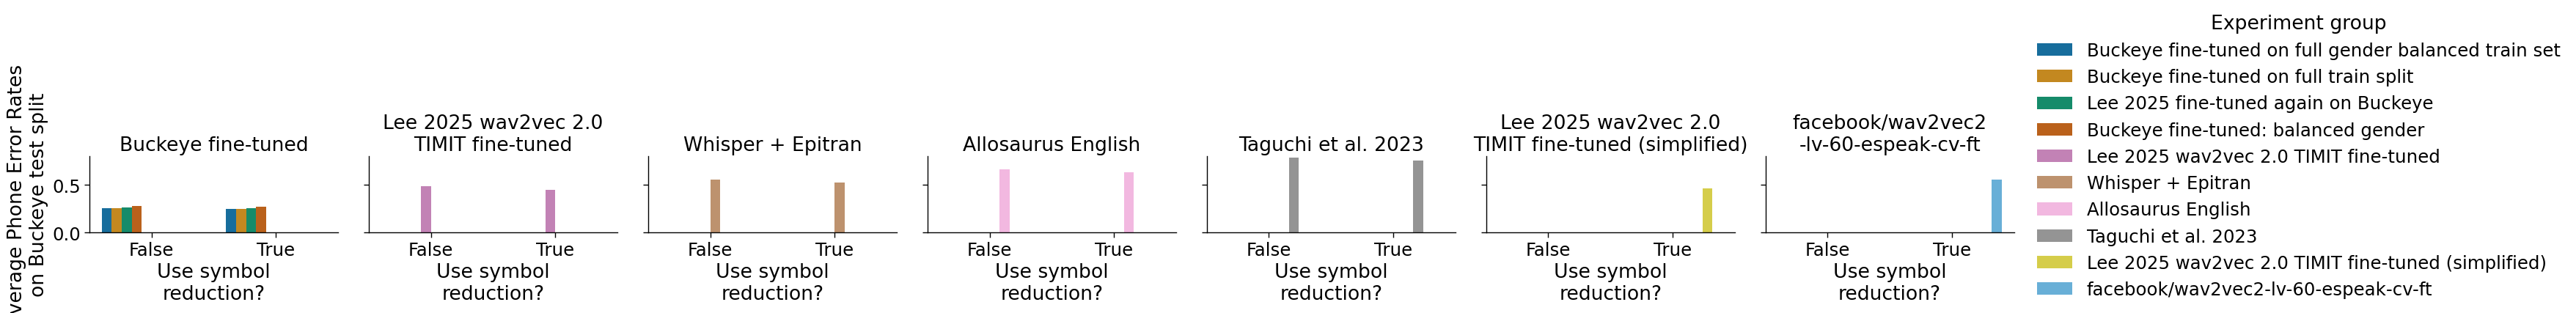

In [23]:
plt.figure(figsize=(8, 12))

# Display side by-side the impact of symbol reduction
g = sns.catplot(joined_best_exp,
                kind="bar",
                col=MODEL_SOURCE_KEY,
                x=symbol_reduction_key,
                y="phone_error_rates",
                hue=EXP_GROUP_DISPLAY_KEY,
                height=4, aspect=1,
                palette=PALETTE
            )
g.set_axis_labels("Use symbol\nreduction?", "Average Phone Error Rates\non Buckeye test split")
g.set(ylim=(0, 0.8))
g.set_titles("{col_name}")

<Figure size 800x1200 with 0 Axes>

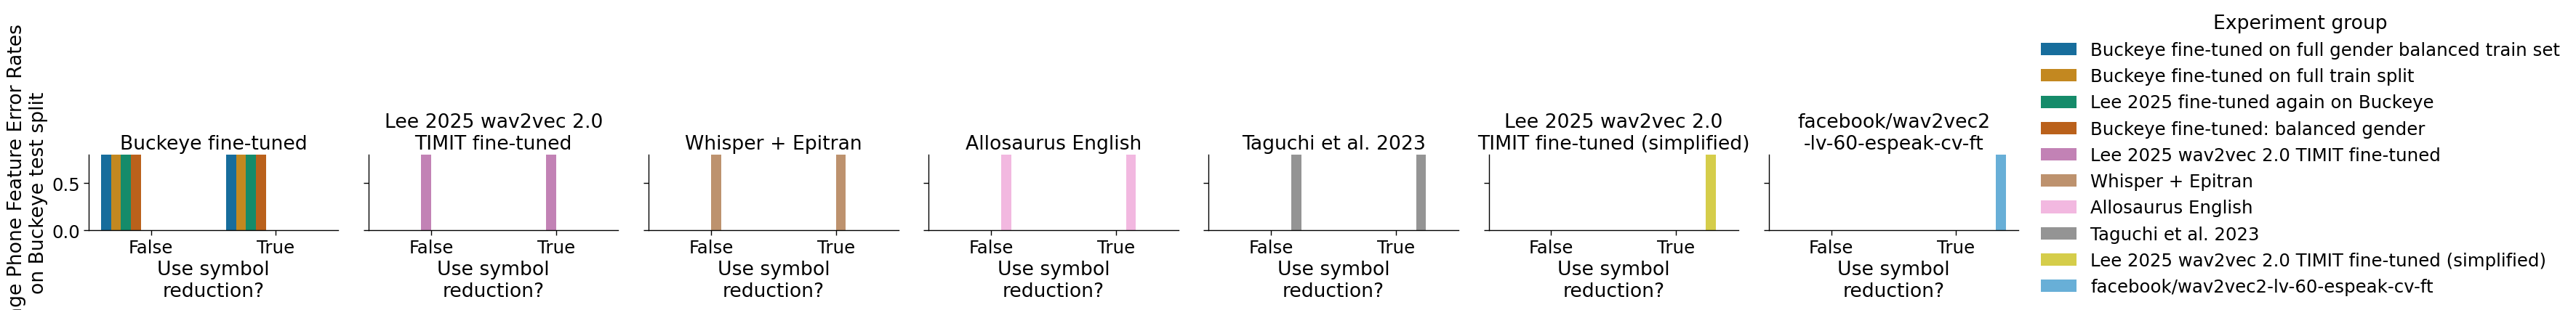

In [24]:
plt.figure(figsize=(8, 12))
# Display side by-side the impact of symbol reduction
g = sns.catplot(joined_best_exp,
                kind="bar",
                col=MODEL_SOURCE_KEY,
                x=symbol_reduction_key,
                y="phone_feature_error_rates",
                hue=EXP_GROUP_DISPLAY_KEY,
                height=4, aspect=1,
                palette=PALETTE
            )
g.set_axis_labels("Use symbol\nreduction?", "Average Phone Feature Error Rates\non Buckeye test split")
g.set(ylim=(0, 0.8))
g.set_titles("{col_name}")